<a href="https://colab.research.google.com/github/neha2075/Fakenews-Detection/blob/main/Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fakenews Detection using Image + Text**

## **Mounting Google Drive**

In [ ]:
# 1. Mount your Google Drive to access the TSV files
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 2. Install required libraries
!pip install transformers torch torchvision pillow pandas requests tqdm
!pip install torchinfo


## **Import Libraries**

In [ ]:

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import requests
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from transformers import BertTokenizer, BertModel
from PIL import Image
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from transformers import BertTokenizer
from google.colab import files
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score





## **Reproducibility & Device**

In [ ]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


## **Load Data & Download Images**

In [ ]:
# 1. Load the TSV
path_to_tsv = '/content/drive/MyDrive/Neural and Deep learning/multimodal_only_samples/multimodal_train.tsv'
df = pd.read_csv(path_to_tsv, sep='\t')

os.makedirs('/content/images', exist_ok=True)

# Attempt to download
subset_df = df.sample(10000).copy()

def download_image(row):
    img_id = row['id']
    url = row['image_url']
    save_path = f"/content/images/{img_id}.jpg"
    if os.path.exists(save_path): return True
    try:
        response = requests.get(url, timeout=5)
        if response.status_code == 200:
            with open(save_path, 'wb') as f:
                f.write(response.content)
            return True
    except:
        return False
    return False


print("Downloading images...")

# Removed 'tqdm' from this line
with ThreadPoolExecutor(max_workers=20) as executor:
    results = list(executor.map(download_image, [row for _, row in subset_df.iterrows()]))

subset_df['download_success'] = results
final_df = subset_df[subset_df['download_success'] == True].head(10000)
final_df.to_csv('final_dataset.csv', index=False)

print(f"Dataset prepared with {len(final_df)} multimodal samples.")

Dataset prepared with 6681 multimodal samples.


In [ ]:
# 1. List the first 10 image filenames in the directory
image_folder = '/content/images'
image_filenames = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]

print(f"Total images found: {len(image_filenames)}")
print("Total text samples:", len(final_df))



Total images found: 6681
Total text samples: 6681


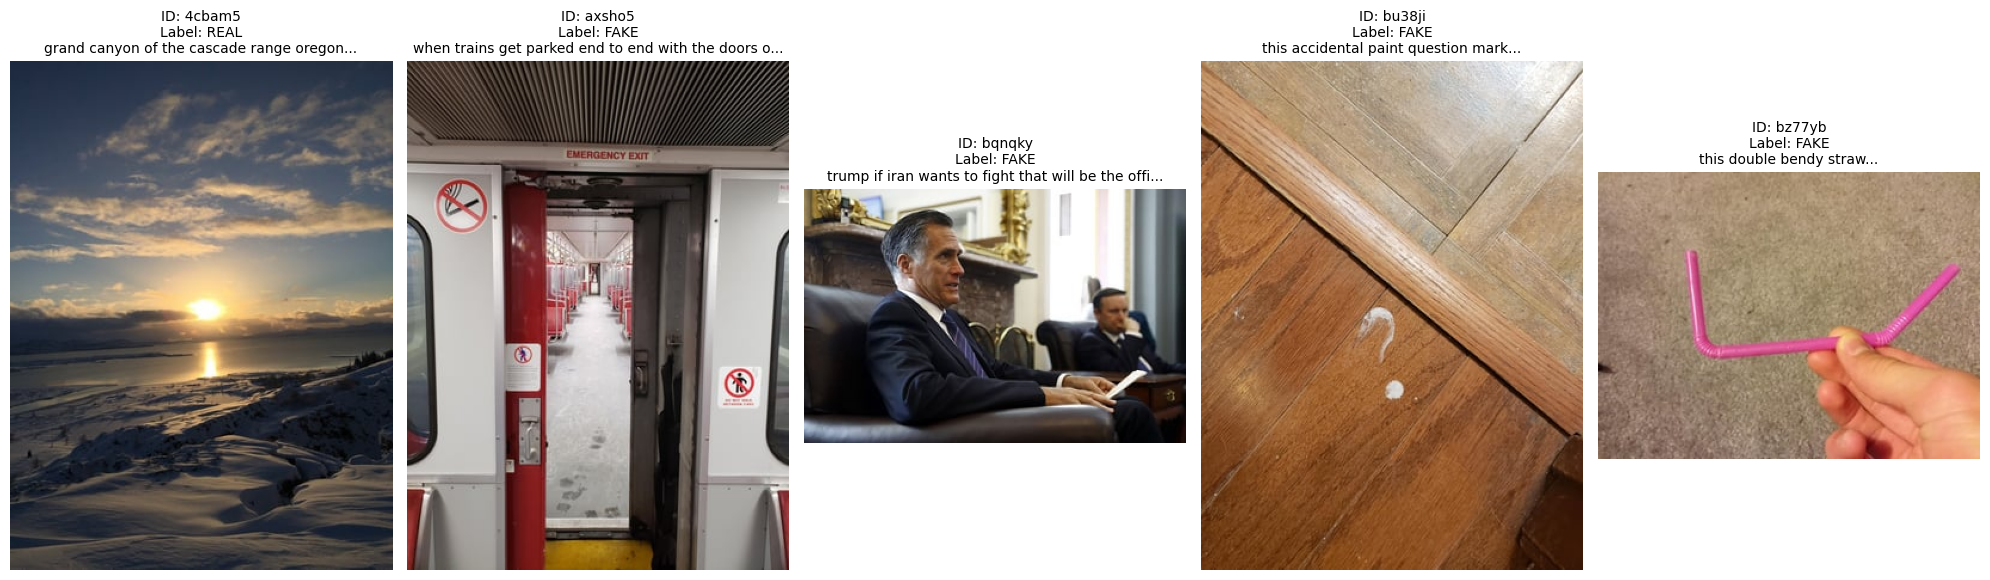

In [ ]:
# 2. Function to show 5 samples
def show_multimodal_samples(df, img_dir, num_samples=5):
    # Select random samples
    samples = df.sample(num_samples)

    plt.figure(figsize=(20, 10))

    for i, (idx, row) in enumerate(samples.iterrows()):
        img_id = row['id']
        img_path = os.path.join(img_dir, f"{img_id}.jpg")

        # Check if image exists (in case it was removed during cleaning)
        if os.path.exists(img_path):
            img = Image.open(img_path)

            plt.subplot(1, num_samples, i + 1)
            plt.imshow(img)

            # Formatting the title for the plot
            label_text = "FAKE" if row['2_way_label'] == 1 else "REAL"
            clean_title = row['clean_title'][:50] + "..."
            plt.title(f"ID: {img_id}\nLabel: {label_text}\n{clean_title}", fontsize=10)
            plt.axis('off')
        else:
            print(f"Skipping {img_id}, file not found.")

    plt.tight_layout()
    plt.show()

# Run the display function
# Use 'final_df' or 'train_df' depending on which one you have in memory
show_multimodal_samples(final_df, '/content/images', num_samples=5)

In [ ]:
DATA_DIR = '/content/drive/MyDrive/Neural and Deep learning/multimodal_only_samples'

def load_data_pairs(directory):
    data = []
    files = os.listdir(directory)

    files_set = set(files)

    ids = set([f.split('.')[0] for f in files])

    print(f"Found {len(ids)} unique identifiers. Processing...")

In [ ]:
# Count Real vs Fake
class_counts = final_df['2_way_label'].value_counts()
print(class_counts)

# Optional: print nicely
print(f"Number of Real news: {class_counts.get(0, 0)}")
print(f"Number of Fake news: {class_counts.get(1, 0)}")


2_way_label
1    3720
0    2961
Name: count, dtype: int64
Number of Real news: 2961
Number of Fake news: 3720


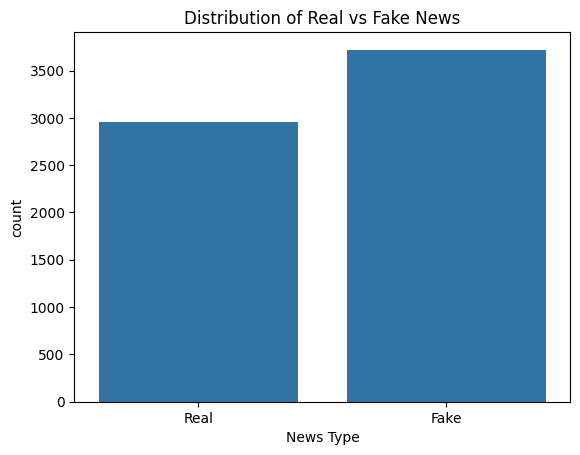

In [ ]:
# Plot with nicer x-axis label
sns.countplot(x=final_df['2_way_label'])
plt.xticks([0, 1], ['Real', 'Fake'])  # human-readable
plt.xlabel("News Type")                # replace 2-way_label
plt.ylabel("count")
plt.title("Distribution of Real vs Fake News")
plt.show()


## **Exploratory Data Analysis (EDA)**

### **Class Balance & Text Length**

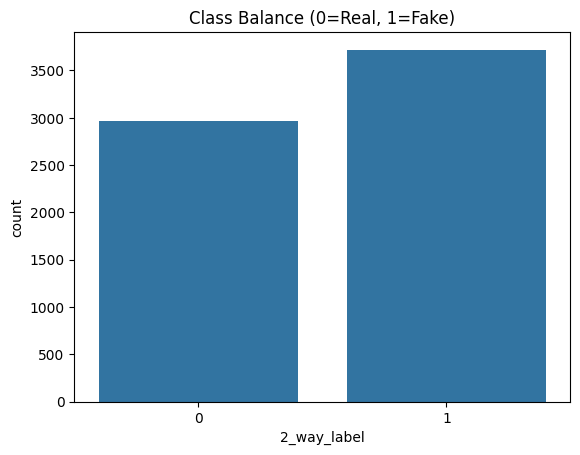

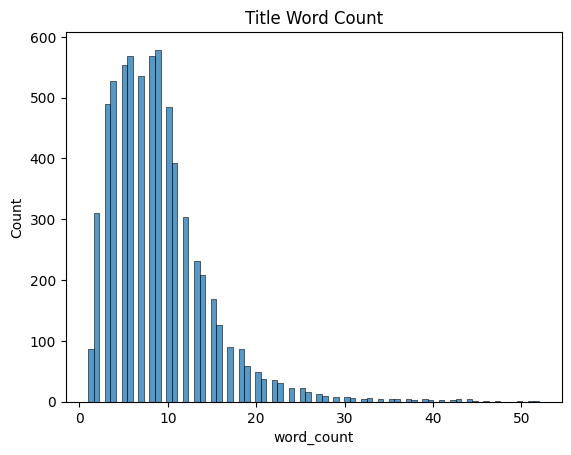

In [ ]:
# Load the subset we just created
data = pd.read_csv('final_dataset.csv')

# 1. Label Distribution
sns.countplot(x='2_way_label', data=data)
plt.title('Class Balance (0=Real, 1=Fake)')
plt.show()

# 2. Text Length
data['word_count'] = data['clean_title'].apply(lambda x: len(str(x).split()))
sns.histplot(data['word_count'])
plt.title('Title Word Count')
plt.show()

### **Text vs Image Alignment**

In [ ]:
# 1. Count Text Rows in your Dataframe
text_count = len(final_df)

# 2. Count Image Files in your Directory
image_files = [f for f in os.listdir('/content/images') if f.endswith('.jpg')]
image_count = len(image_files)

print("--- DATASET SUMMARY ---")
print(f"Total Text Titles: {text_count}")
print(f"Total Image Files: {image_count}")

# 3. Check for Mismatch
if text_count == image_count:
    print("Perfect! You have a 1:1 match between text and images.")
else:
    print(f"Warning: Mismatch! You have {text_count} text rows but {image_count} images.")
    print("This usually happens if some images failed to download.")

--- DATASET SUMMARY ---
Total Text Titles: 6681
Total Image Files: 6681
Perfect! You have a 1:1 match between text and images.


### **Text Analysis: Word Clouds (Real vs Fake)**

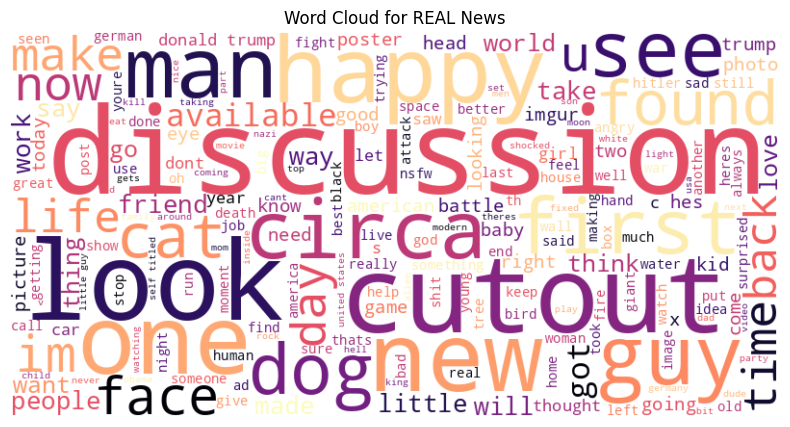

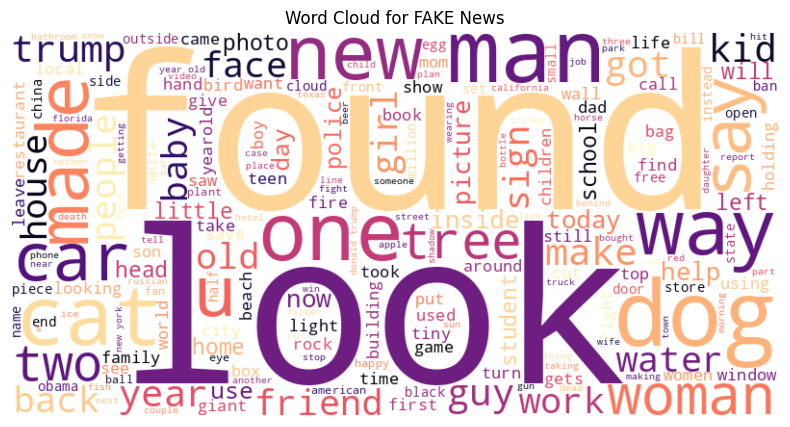

In [ ]:
def plot_wordcloud(label, title_text):
    text = " ".join(df[df['2_way_label'] == label]['clean_title'].astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='magma').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {"FAKE" if label==1 else "REAL"} News')
    plt.axis('off')
    plt.show()

# Run for both classes
plot_wordcloud(0, "Real")
plot_wordcloud(1, "Fake")

### **Image Analysis: Average Brightness and Color**

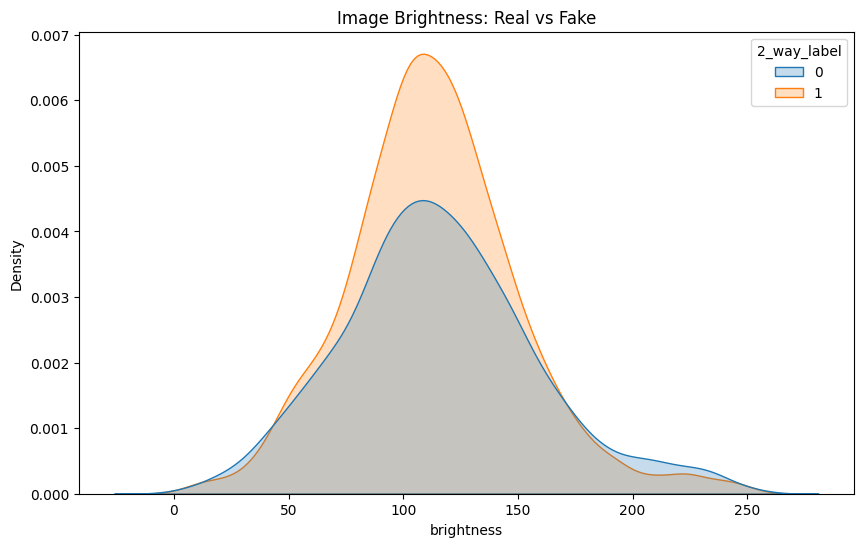

In [ ]:
def get_image_stats(img_path):
    try:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        avg_brightness = np.mean(img)
        # Get average color per channel
        avg_color = np.mean(img, axis=(0, 1))
        return avg_brightness, avg_color[0], avg_color[1], avg_color[2]
    except:
        return None, None, None, None

# Apply to our dataframe
stats = data['id'].apply(lambda x: get_image_stats(f"/content/images/{x}.jpg"))
data[['brightness', 'red', 'green', 'blue']] = pd.DataFrame(stats.tolist(), index=data.index)

# Plot Brightness Distribution
plt.figure(figsize=(10,6))
sns.kdeplot(data=data, x="brightness", hue="2_way_label", fill=True)
plt.title("Image Brightness: Real vs Fake")
plt.show()

### **Text-Image Correlation: Title Length vs. Fakeness**

In [ ]:
# Ensure word_count is calculated
data['word_count'] = data['clean_title'].apply(lambda x: len(str(x).split()))

# Check if we actually have data (this will print the first 5 rows)
print("Data head:")
print(data[['2_way_label', 'word_count']].head())

# Check if there are any Null values
print("\nNull values in columns:")
print(data[['2_way_label', 'word_count']].isnull().sum())

Data head:
   2_way_label  word_count
0            0           1
1            0           7
2            0           3
3            1          12
4            0          12

Null values in columns:
2_way_label    0
word_count     0
dtype: int64


### **Title Word Count Analysis by News Type (Real vs. Fake)**

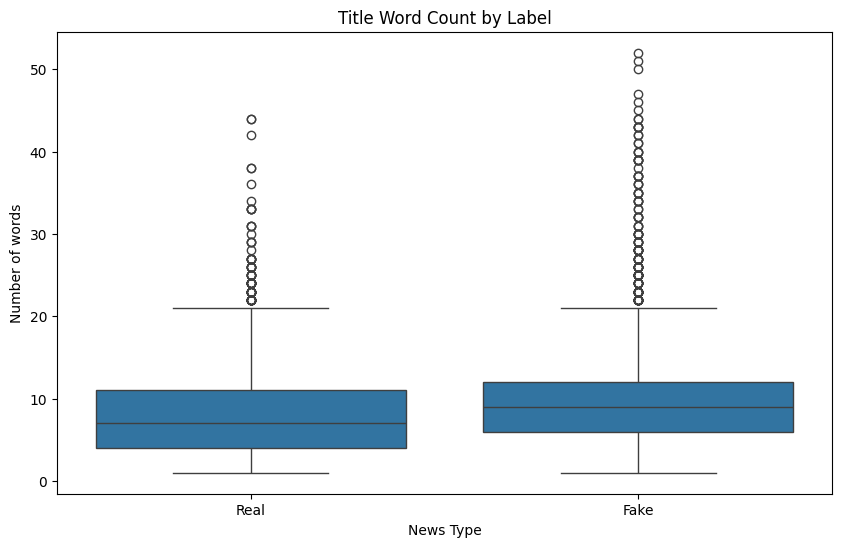

In [ ]:
plt.figure(figsize=(10,6))

# We use 'data=data' and ensure '2_way_label' is treated as a category
sns.boxplot(data=data, x='2_way_label', y='word_count')

plt.title('Title Word Count by Label')
plt.xlabel('News Type')
plt.ylabel('Number of words')

# This ensures the ticks align with whatever values are actually in the column
plt.xticks([0, 1], ['Real', 'Fake'])

plt.show()

## **Remove corrupted**

In [ ]:
# -----------------------------
# Define function first
# -----------------------------
def clean_corrupted_images(dataframe, img_dir):
    print(f"Starting integrity check on {len(dataframe)} images...")
    valid_indices = []
    removed = 0

    for idx, row in tqdm(dataframe.iterrows(), total=len(dataframe)):
        img_id = row['id']
        img_path = os.path.join(img_dir, f"{img_id}.jpg")

        try:
            with Image.open(img_path) as img:
                img.verify()
            valid_indices.append(idx)
        except (IOError, SyntaxError, Image.UnidentifiedImageError):
            print(f"Removing corrupted image: {img_id}")
            removed += 1
            if os.path.exists(img_path):
                os.remove(img_path)

    cleaned_df = dataframe.loc[valid_indices].reset_index(drop=True)

    print("Total corrupted images removed:", removed)
    print("Total remaining valid images:", len(cleaned_df))

    return cleaned_df

# -----------------------------
# Now call the function
# -----------------------------
cleaned_df = clean_corrupted_images(final_df, "/content/images")


Starting integrity check on 6681 images...


  8%|▊         | 561/6681 [00:00<00:01, 5609.52it/s]

Removing corrupted image: cw74890
Removing corrupted image: dq4x5ki
Removing corrupted image: d1v7bwy


 77%|███████▋  | 5135/6681 [00:00<00:00, 6305.48it/s]

Removing corrupted image: c89lshc


100%|██████████| 6681/6681 [00:01<00:00, 6313.12it/s]

Total corrupted images removed: 4
Total remaining valid images: 6677


## **Dataset Class and Tokenizer**

In [ ]:
class MultiModalDataset(Dataset):
    def __init__(self, dataframe, img_dir, tokenizer, max_len=64):
        self.df = dataframe
        self.img_dir = img_dir
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = str(row['clean_title'])
        label = int(row['2_way_label'])
        img_id = row['id']

        # Text Processing
        encoding = self.tokenizer(
            text, truncation=True, padding='max_length',
            max_length=self.max_len, return_tensors='pt'
        )

        # IMAGE PROCESSING (FIXED VERSION)
        img_path = os.path.join(self.img_dir, f"{img_id}.jpg")

        # We open the image and immediately convert it to RGB
        # This fixes the "Palette images with Transparency" warning
        image = Image.open(img_path).convert('RGB')

        image = self.transform(image)

        return {
            'ids': encoding['input_ids'].flatten(),
            'mask': encoding['attention_mask'].flatten(),
            'image': image,
            'label': torch.tensor(label, dtype=torch.long)
        }


        # Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
print(" Tokenizer defined successfully!")

 Tokenizer defined successfully!


## **Data Splitting**

In [ ]:
# 1. Load your downloaded dataset (ensure this file was created in your download step)
df = pd.read_csv('final_dataset.csv')

# 2. Split: 80% Train, 20% Temporary (which we will split again)
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['2_way_label'])

# 3. Split the 20% Temporary into: 10% Validation and 10% Test
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['2_way_label'])

print(f"Splitting complete!")
print(f"Initial counts -> Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")





Splitting complete!
Initial counts -> Train: 5344, Val: 668, Test: 669


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv('final_dataset.csv')

# Split: 80% Train, 20% Temp
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['2_way_label'])

# Split Temp into 10% Val, 10% Test
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['2_way_label'])

# Function to count Real and Fake
def count_labels(data, name):
    real = (data['2_way_label'] == 0).sum()
    fake = (data['2_way_label'] == 1).sum()
    return [name, real, fake, len(data)]

# Create table
table = pd.DataFrame([
    count_labels(train_df, "Train"),
    count_labels(val_df, "Validation"),
    count_labels(test_df, "Test")
], columns=["Split", "Real (0)", "Fake (1)", "Total Samples"])

# Display table
table


,Split,Real (0),Fake (1),Total Samples
0,Train,2368,2976,5344
1,Validation,296,372,668
2,Test,297,372,669


## **Data Cleaning**

In [ ]:

def clean_dataset_integrity(dataframe, img_dir):
    print(f"Checking integrity of {len(dataframe)} images...")
    valid_indices = []

    for idx, row in tqdm(dataframe.iterrows(), total=len(dataframe)):
        img_path = os.path.join(img_dir, f"{row['id']}.jpg")

        try:
            # Try to open and verify the image
            with Image.open(img_path) as img:
                img.verify()
            valid_indices.append(idx)
        except Exception:
            # If image is corrupted, it will not be added to valid_indices
            continue

    return dataframe.loc[valid_indices].reset_index(drop=True)

# Apply cleaning to all your data splits
print("Cleaning Training Data...")
train_df = clean_dataset_integrity(train_df, '/content/images')

print("Cleaning Validation Data...")
val_df = clean_dataset_integrity(val_df, '/content/images')

print("Cleaning Test Data...")
test_df = clean_dataset_integrity(test_df, '/content/images')

# RE-INITIALIZE LOADERS with the cleaned dataframes
train_loader = DataLoader(MultiModalDataset(train_df, '/content/images', tokenizer), batch_size=16, shuffle=True)
val_loader = DataLoader(MultiModalDataset(val_df, '/content/images', tokenizer), batch_size=16)
test_loader = DataLoader(MultiModalDataset(test_df, '/content/images', tokenizer), batch_size=16)

print(f" Ready! Cleaned counts: Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)}")

Cleaning Training Data...
Checking integrity of 5344 images...


100%|██████████| 5344/5344 [00:00<00:00, 6596.62it/s]


Cleaning Validation Data...
Checking integrity of 668 images...


100%|██████████| 668/668 [00:00<00:00, 6772.22it/s]


Cleaning Test Data...
Checking integrity of 669 images...


100%|██████████| 669/669 [00:00<00:00, 6443.07it/s]

 Ready! Cleaned counts: Train=5341, Val=668, Test=668


## **Multi-Modal Model Architecture (Late Fusion)**

In [ ]:
# 1. Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [ ]:
class MultiModalClassifier(nn.Module):
    def __init__(self):
        super(MultiModalClassifier, self).__init__()

        # Branch 1: BERT
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Branch 2: ResNet18
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.vision_backbone = nn.Sequential(*list(resnet.children())[:-1])

        # Fusion Layer: BERT(768) + ResNet(512) = 1280
        self.fusion_layer = nn.Sequential(
            nn.Linear(768 + 512, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 2) # Binary Output (Real/Fake)
        )

    def forward(self, ids, mask, images):
        # NLP features
        text_features = self.bert(input_ids=ids, attention_mask=mask).pooler_output

        # CV features
        image_features = self.vision_backbone(images)
        image_features = torch.flatten(image_features, 1)

        # Concatenate and Classify
        combined = torch.cat((text_features, image_features), dim=1)
        return self.fusion_layer(combined)

model = MultiModalClassifier().to(device)


def predict_news(text, image_path, model, tokenizer, device):
    model.eval()

    encoding = tokenizer(
        text, truncation=True, padding='max_length',
        max_length=64, return_tensors='pt'
    )

    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
    image = transform(image).unsqueeze(0)

    with torch.no_grad():
        outputs = model(
            encoding['input_ids'].to(device),
            encoding['attention_mask'].to(device),
            image.to(device)
        )
        probs = torch.softmax(outputs, dim=1)
        pred = torch.argmax(probs, dim=1).item()

    label = "FAKE" if pred == 1 else "REAL"
    confidence = probs[0][pred].item() * 100
    return label, confidence




In [ ]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable = total - trainable

    print("\n===== PARAMETER COUNT =====")
    print(f"Total Parameters      : {total:,}")
    print(f"Trainable Parameters : {trainable:,}")
    print(f"Non-Trainable Params : {non_trainable:,}")
    print("===========================\n")


In [ ]:
from torchinfo import summary

model = MultiModalClassifier().to(device)

count_parameters(model)


summary(
    model,
    input_data=(
        torch.randint(0, 1000, (1, 64)).to(device),
        torch.ones((1, 64)).to(device),
        torch.randn(1, 3, 224, 224).to(device)
    ),
    col_names=["input_size", "output_size", "num_params", "trainable"]
)



===== PARAMETER COUNT =====
Total Parameters      : 121,315,650
Trainable Parameters : 121,315,650
Non-Trainable Params : 0



Layer (type:depth-idx)                                       Input Shape               Output Shape              Param #                   Trainable
MultiModalClassifier                                         [1, 64]                   [1, 2]                    --                        True
├─BertModel: 1-1                                             --                        [1, 768]                  --                        True
│    └─BertEmbeddings: 2-1                                   --                        [1, 64, 768]              --                        True
│    │    └─Embedding: 3-1                                   [1, 64]                   [1, 64, 768]              23,440,896                True
│    │    └─Embedding: 3-2                                   [1, 64]                   [1, 64, 768]              1,536                     True
│    │    └─Embedding: 3-3                                   [1, 64]                   [1, 64, 768]              393,216           

## **Training Loop**

In [ ]:
def validate(model, val_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in val_loader:
            ids = batch['ids'].to(device)
            mask = batch['mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(ids, mask, images)
            _, preds = torch.max(outputs, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    model.train()
    return correct / total


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiModalClassifier().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# ----- Class imbalance handling -----
class_counts = train_df['2_way_label'].value_counts().sort_index()
weights = 1. / torch.tensor(class_counts.values, dtype=torch.float)
criterion = nn.CrossEntropyLoss(weight=weights.to(device))

epochs = 10
train_losses = []
val_accuracies = []

model.train()

for epoch in range(epochs):
    total_loss = 0
    loop = tqdm(train_loader, leave=True)

    for batch in loop:
        try:
            optimizer.zero_grad()
            ids = batch['ids'].to(device)
            mask = batch['mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(ids, mask, images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
            loop.set_postfix(loss=loss.item())
        except Exception as e:
            print(f"Skipping a batch due to error: {e}")
            continue

    val_acc = validate(model, val_loader, device)
    print(f"Validation Accuracy after Epoch {epoch+1}: {val_acc*100:.2f}%")

    train_losses.append(total_loss / len(train_loader))
    val_accuracies.append(val_acc)   # <-- fixed indentation

    print(f"Epoch {epoch+1} completed. Avg Loss: {total_loss/len(train_loader):.4f}")

# Save the trained model
model_path = "/content/drive/MyDrive/multimodal_fakenews_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved successfully at: {model_path}")


Epoch [1/10]:  21%|██▏       | 71/334 [00:21<01:19,  3.31it/s, loss=0.598]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch [1/10]: 100%|██████████| 334/334 [01:45<00:00,  3.18it/s, loss=0.494]


Validation Accuracy after Epoch 1: 77.84%
Epoch 1 completed. Avg Loss: 0.5576


Epoch [2/10]: 100%|██████████| 334/334 [01:46<00:00,  3.14it/s, loss=0.184]


Validation Accuracy after Epoch 2: 80.84%
Epoch 2 completed. Avg Loss: 0.3509


Epoch [3/10]: 100%|██████████| 334/334 [01:42<00:00,  3.25it/s, loss=0.458]


Validation Accuracy after Epoch 3: 80.39%
Epoch 3 completed. Avg Loss: 0.1678


Epoch [4/10]: 100%|██████████| 334/334 [01:38<00:00,  3.37it/s, loss=0.154]


Validation Accuracy after Epoch 4: 80.24%
Epoch 4 completed. Avg Loss: 0.0672


Epoch [5/10]: 100%|██████████| 334/334 [01:38<00:00,  3.38it/s, loss=0.00489]


Validation Accuracy after Epoch 5: 80.69%
Epoch 5 completed. Avg Loss: 0.0309


Epoch [6/10]: 100%|██████████| 334/334 [01:39<00:00,  3.37it/s, loss=0.00358]


Validation Accuracy after Epoch 6: 80.69%
Epoch 6 completed. Avg Loss: 0.0205


Epoch [7/10]: 100%|██████████| 334/334 [01:38<00:00,  3.38it/s, loss=0.000412]


Validation Accuracy after Epoch 7: 79.19%
Epoch 7 completed. Avg Loss: 0.0247


Epoch [8/10]: 100%|██████████| 334/334 [01:39<00:00,  3.36it/s, loss=0.0113]


Validation Accuracy after Epoch 8: 80.24%
Epoch 8 completed. Avg Loss: 0.0151


Epoch [9/10]: 100%|██████████| 334/334 [01:39<00:00,  3.37it/s, loss=0.121]


Validation Accuracy after Epoch 9: 79.34%
Epoch 9 completed. Avg Loss: 0.0159


Epoch [10/10]: 100%|██████████| 334/334 [01:39<00:00,  3.36it/s, loss=0.000198]


Validation Accuracy after Epoch 10: 81.59%
Epoch 10 completed. Avg Loss: 0.0182
Model saved successfully at: /content/drive/MyDrive/multimodal_fakenews_model.pth


## **Training Loss Curve**

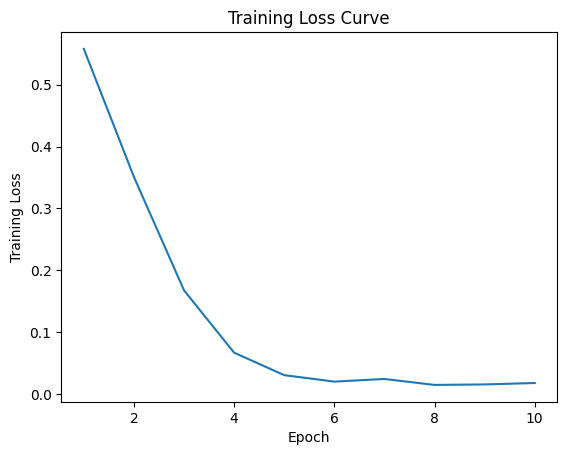

In [ ]:
plt.figure()
plt.plot(range(1, len(train_losses)+1), train_losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Curve")
plt.show()




## **Validation Accuracy Curve**

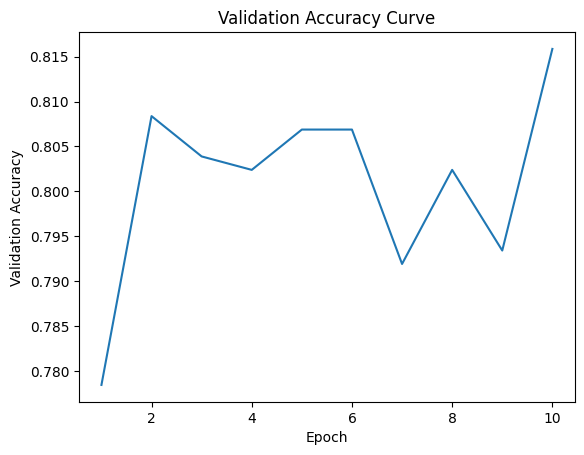

In [ ]:
plt.figure()
plt.plot(range(1, len(val_accuracies)+1), val_accuracies)
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy Curve")
plt.show()

## **Evaluation**

In [ ]:
class TextOnlyClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.classifier = nn.Linear(768, 2)

    def forward(self, ids, mask):
        outputs = self.bert(input_ids=ids, attention_mask=mask)
        pooled = outputs.pooler_output
        return self.classifier(pooled)


In [ ]:
text_model = TextOnlyClassifier().to(device)
text_model.eval()  # evaluation only


TextOnlyClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

### **Text-only Baseline Evaluation**

In [ ]:
def evaluate_text_only_comprehensive(model, loader, device, model_name="Text-Only"):
    model.eval()
    all_labels, all_preds, all_probs = [], [], []

    with torch.no_grad():
        for batch in tqdm(loader):
            ids = batch['ids'].to(device)
            mask = batch['mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(ids, mask)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(outputs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy()[:, 1])

    # metrics (same as before)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')

    try: logloss = log_loss(all_labels, all_probs)
    except: logloss = None
    try: auc = roc_auc_score(all_labels, all_probs)
    except: auc = None

    # Print summary
    print(f"\n{'='*15} {model_name} EVALUATION {'='*15}")
    print(f"Accuracy : {acc:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
    if logloss: print(f"Log Loss : {logloss:.4f}")
    if auc: print(f"ROC-AUC  : {auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real','Fake'], yticklabels=['Real','Fake'])
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.show()

    return {
        'metrics': {
            'Accuracy': acc,
            'F1 Score': f1,
            'Precision': precision,
            'Recall': recall,
            'Log Loss': logloss,
            'ROC-AUC': auc
        },
        'labels': all_labels,
        'preds': all_preds,
        'probs': all_probs
    }


100%|██████████| 42/42 [00:11<00:00,  3.80it/s]



=============== Text-Only EVALUATION ===============
Accuracy : 0.5165, F1: 0.5148, Precision: 0.5335, Recall: 0.5165
ROC-AUC  : 0.5371


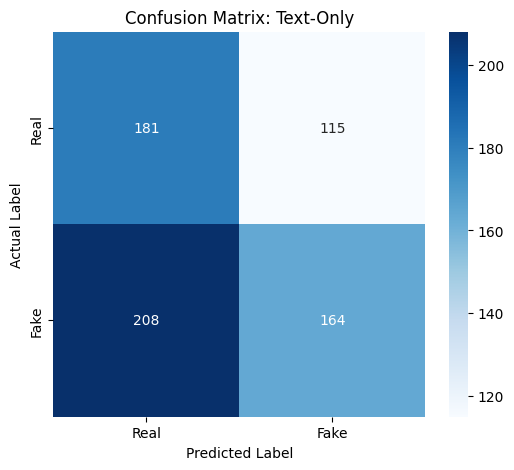

In [ ]:
text_eval = evaluate_text_only_comprehensive(
    model=text_model,
    loader=test_loader,
    device=device
)

### **Image-only Baseline Evaluation**

In [ ]:
import torch.nn as nn
import torchvision.models as models

class ImageOnlyClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])  # remove FC
        self.classifier = nn.Linear(512, 2)

    def forward(self, images):
        features = self.backbone(images)
        features = features.view(features.size(0), -1)
        return self.classifier(features)


In [ ]:
image_model = ImageOnlyClassifier().to(device)
image_model.eval()  # set to evaluation mode


ImageOnlyClassifier(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [ ]:
def evaluate_image_only_comprehensive(model, loader, device, model_name="Image-Only"):
    model.eval()
    all_labels, all_preds, all_probs = [], [], []

    with torch.no_grad():
        for batch in tqdm(loader):
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(outputs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy()[:, 1])

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')

    try: logloss = log_loss(all_labels, all_probs)
    except: logloss = None
    try: auc = roc_auc_score(all_labels, all_probs)
    except: auc = None

    print(f"\n{'='*15} {model_name} EVALUATION {'='*15}")
    print(f"Accuracy : {acc:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
    if logloss: print(f"Log Loss : {logloss:.4f}")
    if auc: print(f"ROC-AUC  : {auc:.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real','Fake'], yticklabels=['Real','Fake'])
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.show()

    return {
        'metrics': {
            'Accuracy': acc,
            'F1 Score': f1,
            'Precision': precision,
            'Recall': recall,
            'Log Loss': logloss,
            'ROC-AUC': auc
        },
        'labels': all_labels,
        'preds': all_preds,
        'probs': all_probs
    }


100%|██████████| 42/42 [00:03<00:00, 13.54it/s]



=============== Image-Only EVALUATION ===============
Accuracy : 0.4611, F1: 0.3447, Precision: 0.5532, Recall: 0.4611
ROC-AUC  : 0.4504


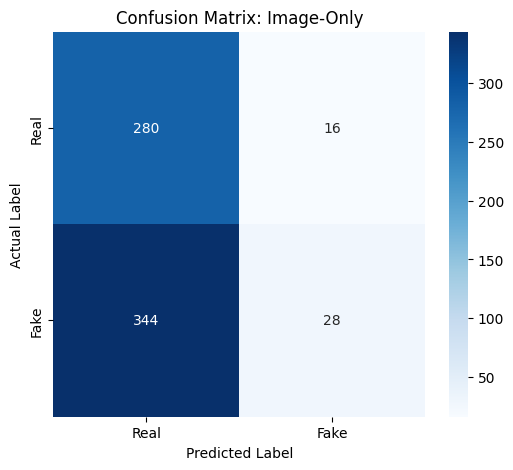

In [ ]:
image_eval = evaluate_image_only_comprehensive(
    model=image_model,
    loader=test_loader,
    device=device
)


### **Multimodal Evaluation(Image+ Text)**

🚀 Evaluating on Test Set...


100%|██████████| 42/42 [00:06<00:00,  6.90it/s]



      CLASSIFICATION REPORT
              precision    recall  f1-score   support

        Real       0.81      0.73      0.77       296
        Fake       0.80      0.87      0.83       372

    accuracy                           0.81       668
   macro avg       0.81      0.80      0.80       668
weighted avg       0.81      0.81      0.80       668



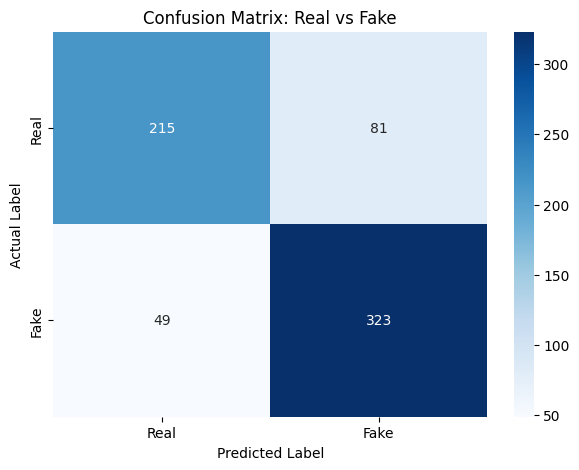

 Final Test ROC-AUC Score: 0.8837


In [ ]:
def evaluate_on_test_set(model, test_loader, device):
    model.eval() # Set model to evaluation mode
    all_preds = []
    all_labels = []
    all_probs = [] # For ROC-AUC calculation

    print("🚀 Evaluating on Test Set...")

    with torch.no_grad():
        for batch in tqdm(test_loader):
            ids = batch['ids'].to(device)
            mask = batch['mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(ids, mask, images)

            # Get probabilities and predictions
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy()[:, 1]) # Probability of being 'Fake'

    # 1. Classification Report
    print("\n" + "="*30)
    print("      CLASSIFICATION REPORT")
    print("="*30)
    print(classification_report(all_labels, all_preds, target_names=['Real', 'Fake']))

    # 2. Confusion Matrix Plot
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.title('Confusion Matrix: Real vs Fake')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # 3. ROC-AUC
    auc_score = roc_auc_score(all_labels, all_probs)
    print(f" Final Test ROC-AUC Score: {auc_score:.4f}")

    return all_labels, all_preds, all_probs

# EXECUTE EVALUATION(Text+Image)
test_labels, test_preds, test_probs = evaluate_on_test_set(model, test_loader, device)



### **Comparison Table**

In [ ]:
# Convert your multimodal evaluation outputs into a results dictionary
results_mm = {
    'Model': 'Multimodal (BERT+ResNet)',
    'Accuracy': accuracy_score(test_labels, test_preds),
    'Precision': precision_score(test_labels, test_preds, average='weighted'),
    'Recall': recall_score(test_labels, test_preds, average='weighted'),
    'F1 Score': f1_score(test_labels, test_preds, average='weighted'),
    'ROC-AUC': roc_auc_score(test_labels, test_probs)
}



# Flatten Text-Only metrics
text_metrics = {'Model': 'Text-Only'}
text_metrics.update(text_eval['metrics'])

# Flatten Image-Only metrics
image_metrics = {'Model': 'Image-Only'}
image_metrics.update(image_eval['metrics'])

# Multimodal metrics are already flat
mm_metrics = results_mm

# Create the comparison DataFrame from the three dictionaries
comparison_results = pd.DataFrame([text_metrics, image_metrics, mm_metrics])

# Reorder columns for clarity
comparison_results = comparison_results[[
    'Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC'
]]

# Round numeric values
for col in ['Accuracy', 'Precision', 'Recall', 'F1 Score',  'ROC-AUC']:
    comparison_results[col] = comparison_results[col].apply(lambda x: round(x, 4) if x is not None else None)

# Display
print("\n===== MODEL COMPARISON TABLE =====")
display(comparison_results)



===== MODEL COMPARISON TABLE =====


,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
0,Text-Only,0.5165,0.5335,0.5165,0.5148,0.5371
1,Image-Only,0.4611,0.5532,0.4611,0.3447,0.4504
2,Multimodal (BERT+ResNet),0.8054,0.8061,0.8054,0.8038,0.8837


### **ROC Curve Plot**

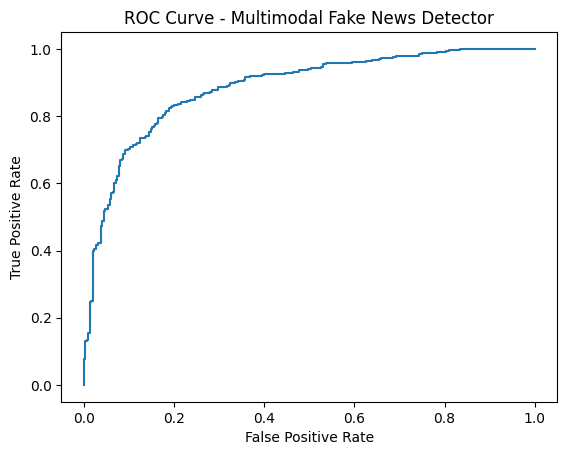

In [ ]:
fpr, tpr, _ = roc_curve(test_labels, test_probs)
plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Multimodal Fake News Detector")
plt.show()


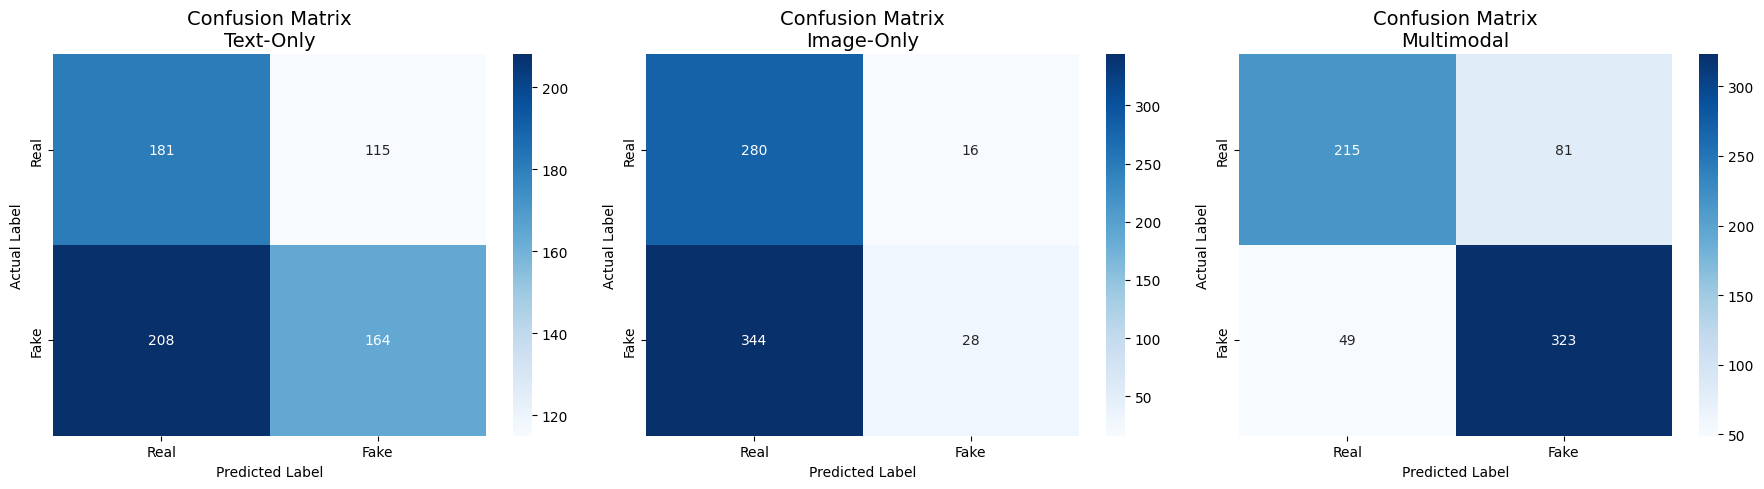

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrices(models_info, labels=['Real', 'Fake']):
    """
    models_info: list of tuples -> [(model_name, y_true, y_pred), ...]
    """
    num_models = len(models_info)
    fig, axes = plt.subplots(1, num_models, figsize=(6*num_models, 5))

    if num_models == 1:
        axes = [axes]  # Ensure axes is iterable

    for ax, (name, y_true, y_pred) in zip(axes, models_info):
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=labels, yticklabels=labels, ax=ax)
        ax.set_title(f'Confusion Matrix\n{name}', fontsize=14)
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('Actual Label')

    plt.tight_layout()
    plt.show()

# -----------------------------
# EXECUTE SIDE-BY-SIDE PLOT
# -----------------------------
models_info = [
    ('Text-Only', text_eval['labels'], text_eval['preds']),
    ('Image-Only', image_eval['labels'], image_eval['preds']),
    ('Multimodal', test_labels, test_preds)
]

plot_confusion_matrices(models_info)





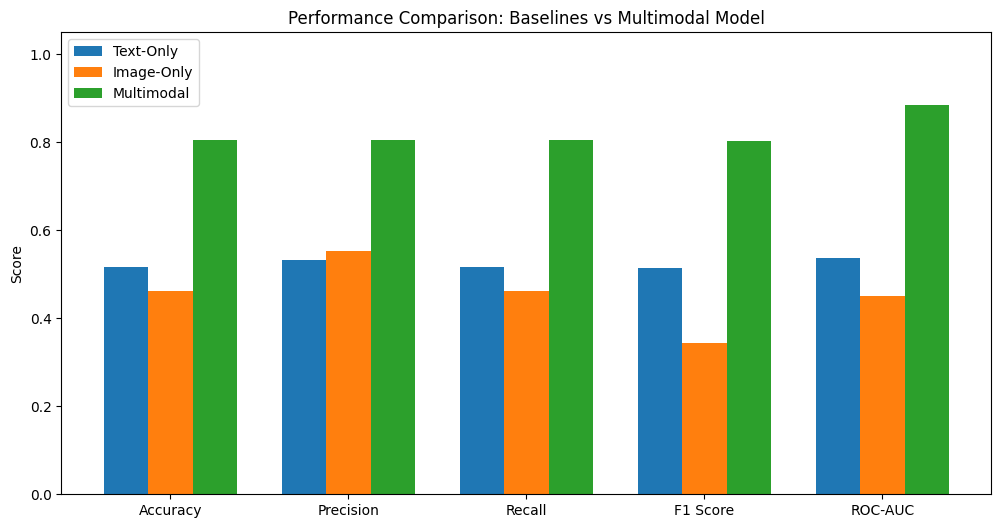

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

models = ['Text-Only', 'Image-Only', 'Multimodal']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']
num_metrics = len(metrics)
width = 0.25

# Collect metrics in the correct shape (models x metrics)
values = np.array([
    [text_eval['metrics'][m] for m in metrics],
    [image_eval['metrics'][m] for m in metrics],
    [results_mm[m] for m in metrics]
])

x = np.arange(num_metrics)  # positions of metrics on x-axis

fig, ax = plt.subplots(figsize=(12,6))

# Plot bars for each model
for i, model in enumerate(models):
    ax.bar(x + (i - 1)*width, values[i], width, label=model)

ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1.05)
ax.set_ylabel('Score')
ax.set_title('Performance Comparison: Baselines vs Multimodal Model')
ax.legend()
plt.show()


## **Run Test on New Data**

In [ ]:
# List the first 5 images in your folder
image_files = os.listdir('/content/images')
print("Here are some valid image files you can use for testing:")
for img in image_files[:5]:
    print(img)

Here are some valid image files you can use for testing:
7csbcq.jpg
5kh2ts.jpg
1ayye2.jpg
3461s7.jpg
ax69a7.jpg


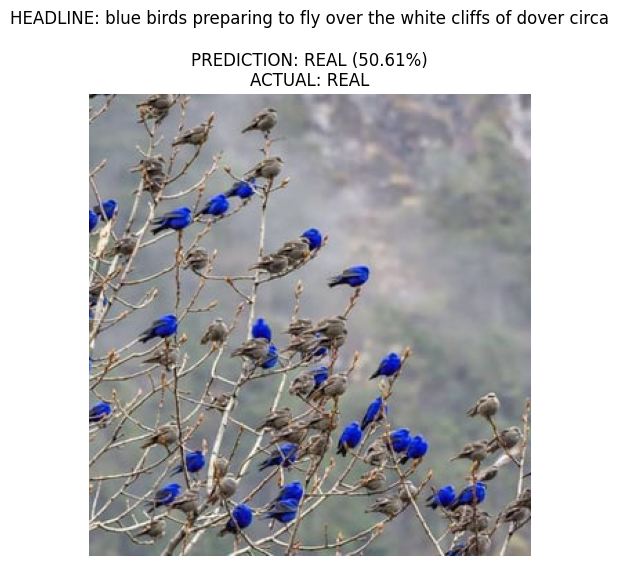

In [ ]:
def predict_by_image_name(img_filename, dataframe, model, tokenizer, device):

    # 1. Extract ID from filename
    img_id = img_filename.replace('.jpg', '').replace('.png', '')

    # 2. Look up the headline in the dataframe
    match = dataframe[dataframe['id'] == img_id]

    if match.empty:
        print(f"Error: ID {img_id} not found in the dataset CSV.")
        return

    original_headline = match['clean_title'].values[0]
    actual_label = "FAKE" if match['2_way_label'].values[0] == 1 else "REAL"

    # 3. Prepare image path
    img_path = os.path.join('/content/images', img_filename)
    if not os.path.exists(img_path):
        print(f"Error: Image file {img_filename} not found in /content/images")
        return

    # 4. Get prediction
    try:
        prediction, confidence = predict_news(original_headline, img_path, model, tokenizer, device)
    except Exception as e:
        print(f"Prediction failed: {e}")
        return

    # 5. Display image and results
    img = Image.open(img_path).convert("RGB")  # convert to RGB to avoid PIL warnings
    plt.figure(figsize=(8,6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"HEADLINE: {original_headline}\n\nPREDICTION: {prediction} ({confidence:.2f}%)\nACTUAL: {actual_label}")
    plt.show()

# --- EXECUTE ---
# Use the cleaned dataframe to ensure no missing or corrupted images
predict_by_image_name("clkn2z.jpg", cleaned_df, model, tokenizer, device)


## **Real Implementation**

Select an image from your computer:


Saving latest.avif to latest (3).avif

Type the headline for this news: news will start in 60 seconds


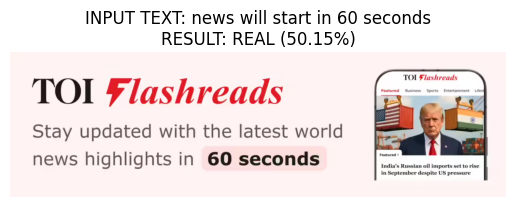

In [ ]:
from transformers import BertTokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# 1. Upload File
print("Select an image from your computer:")
uploaded = files.upload()
new_img_path = list(uploaded.keys())[0]

# 2. Input Headline
new_headline = input("\nType the headline for this news: ")

# 3. Predict
prediction, confidence = predict_news(new_headline, new_img_path, model, tokenizer, device)

# 4. Show Result
img = Image.open(new_img_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"INPUT TEXT: {new_headline}\nRESULT: {prediction} ({confidence:.2f}%)")
plt.show()